In [1]:
import pandas as pd
import seaborn as sns

df = sns.load_dataset("titanic")
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [2]:
X = df[["class", "sex", "embark_town", "fare", "age"]]
y = df.survived

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
X_train.shape, X_test.shape

((668, 5), (223, 5))

In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklego.meta import Thresholder


def make_pipeline(
    num_method, cat_method, encoder, sc_variables, C, threshold=0.5
):
    scaler = SklearnTransformerWrapper(
        StandardScaler(), variables=sc_variables
    )

    print(f"Entrenamiento para C={C} y threshold = {threshold}")
    print("===================================")
    pipe = Pipeline(
        steps=[
            ("num_imp", MeanMedianImputer(imputation_method=num_method)),
            ("cat_imp", CategoricalImputer(imputation_method=cat_method)),
            ("ohe", encoder),
            ("sc", scaler),
            (
                "model",
                Thresholder(
                    LogisticRegression(
                        C=C, random_state=42, max_iter=10000
                    ),
                    threshold=threshold,
                ),
            ),
        ]
    )
    return pipe


def make_evaluation(
    model,
    X_train,
    X_test,
    y_train,
    y_test,
):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred)
    train_precision = precision_score(y_train, y_pred_train)
    test_precision = precision_score(y_test, y_pred)
    train_recall = recall_score(y_train, y_pred_train)
    test_recall = recall_score(y_test, y_pred)

    print(f"Train Accuracy {train_acc}")
    print(f"Test Accuracy {test_acc}")
    print("===================================")
    print(f"Train Precision {train_precision}")
    print(f"Test Precision {test_precision}")
    print("===================================")
    print(f"Train Recall {train_recall}")
    print(f"Test Recall {test_recall}")

    print("===================================")
    print(f"Coeficientes: {model[-1].estimator_.coef_}")
    print(f"Coeficientes: {model[-1].estimator_.intercept_}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    RocCurveDisplay.from_predictions(y_test, y_pred_proba[:, 1])

Entrenamiento para C=10 y threshold = 0.6
Train Accuracy 0.8068862275449101
Test Accuracy 0.8026905829596412
Train Precision 0.8444444444444444
Test Precision 0.8082191780821918
Train Recall 0.6007905138339921
Test Recall 0.6629213483146067
Coeficientes: [[ 0.08468769 -0.35930833  0.91502373 -1.02074655  0.36843929 -1.13894327
   1.40165975 -0.60754774  0.03083727 -0.10686131  0.94628825]]
Coeficientes: [0.3325951]


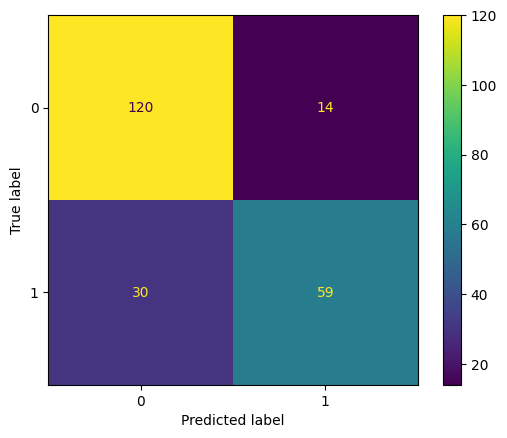

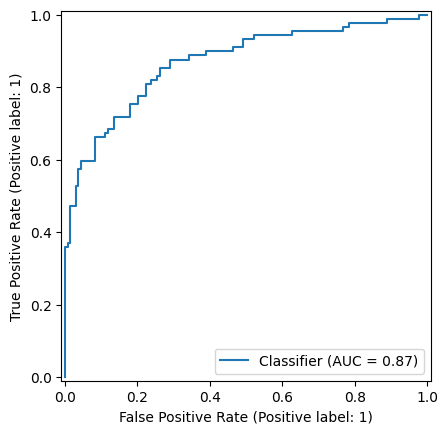

In [17]:
pipe = make_pipeline(
    num_method="mean",
    cat_method="missing",
    encoder=OneHotEncoder(),
    sc_variables=["age", "fare"],
    C=10,
    threshold=0.6,
)

make_evaluation(pipe, X_train, X_test, y_train, y_test)

> Importante, normalemente es buena idea escoger sólo una métrica. O darle más preponderancia a una métrica, ya que el mejor modelo puede ser muy distinto dependiendo de la métrica a utilizar.